# Rainfall in Singapore

***

## Contents
[1. Overview](#1)<br>
[2. Monthly Rainfall Recorded at Changi Climate Station](#2)<br>
&emsp;    [2.1. Data](#2.1)<br>
&emsp;    [2.2. Exploratory Analysis](#2.2)<br>
&emsp;    [2.3. ARIMA Forecast](#2.3)<br>
&emsp;    [2.4. ETS Forecast](#2.4)<br>
&emsp;    [2.5. LASSO Regression Forecast](#2.5)<br>
&emsp;    [2.6. Neural Network Forecast](#2.6)<br>
[3. Daily Rainfall Recorded at Various Weather Stations Around Singapore](#3)<br>
&emsp;    [3.1. Data](#3.1)<br>
&emsp;    [3.2. Exploratory Analysis](#3.2)<br>
[4. Conclusion](#4)<br>

***

<a id = '1'></a>
### 1. Overview
In this notebook we will be exploring rainfall patterns in Singapore, showing the seasonal patterns of rainfall and how some areas of the island receive more rainfall than others. Models will also be built and tested to forecast monthly rainfall on the island.<br><br>
Embedded below is a tableau dashboard visualising some of the data and findings of this notebook.

In [35]:
%%HTML
<div class='tableauPlaceholder' id='viz1629796412796' style='position: relative'><noscript><a href='#'><img alt='Rainfall in Singapore ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;as&#47;asdasdasd_16292772969130&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='asdasdasd_16292772969130&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;as&#47;asdasdasd_16292772969130&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1629796412796');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1600px';vizElement.style.height='927px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1600px';vizElement.style.height='927px';} else { vizElement.style.width='100%';vizElement.style.height='1677px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

***
<a id = '2'></a>
### 2. Monthly Rainfall Recorded at Changi Climate Station
<a id = '2.1'></a>
#### 2.1 Data
For this section we will be using data obtained from [Data.gov.sg](https://data.gov.sg/search?groups=environment), notably the datasets containing rainfall, sunshine duration, wetbulb temperature, and relative humidity data.

In [2]:
# Data collected from Changi Climate Station
rainfall_highest_daily = pd.read_csv(r'data_gov/rainfall-monthly-highest-daily-total.csv') # highest rainfall recorded per month
rainfall_monthly_number = pd.read_csv(r'data_gov/rainfall-monthly-number-of-rain-days.csv') # number of days with rain recorded per month
rainfall_monthly_total = pd.read_csv(r'data_gov/rainfall-monthly-total.csv')    # total rainfall recorded per month
sunshine_duration = pd.read_csv(r'data_gov/sunshine-duration-monthly-mean-daily-duration.csv') # mean hours of sunshine recorded daily per month
wetbulb_temp = pd.read_csv(r'data_gov/wet-bulb-temperature-hourly.csv') # hourly wetbulb temp recorded daily
relative_humidity = pd.read_csv(r'data_gov/relative-humidity-monthly-mean.csv') # monthly mean relative humidity

# Check head
print(rainfall_highest_daily.head())
print(rainfall_monthly_number.head())
print(rainfall_monthly_total.head())
print(sunshine_duration.head())
print(wetbulb_temp.head())

# Check nan
print(rainfall_highest_daily.isnull().sum())
print(rainfall_monthly_number.isnull().sum())
print(rainfall_monthly_total.isnull().sum())
print(sunshine_duration.isnull().sum())
print(wetbulb_temp.isnull().sum())

     month  maximum_rainfall_in_a_day
0  1982-01                       36.5
1  1982-02                        9.4
2  1982-03                       61.7
3  1982-04                       45.1
4  1982-05                       33.0
     month  no_of_rainy_days
0  1982-01                10
1  1982-02                 5
2  1982-03                11
3  1982-04                14
4  1982-05                10
     month  total_rainfall
0  1982-01           107.1
1  1982-02            27.8
2  1982-03           160.8
3  1982-04           157.0
4  1982-05           102.2
     month  mean_sunshine_hrs
0  1982-01                5.6
1  1982-02                7.6
2  1982-03                5.1
3  1982-04                4.7
4  1982-05                5.8
     wbt_date  wbt_time  wet_bulb_temperature
0  1982-01-01         1                  24.7
1  1982-01-01         2                  24.5
2  1982-01-01         3                  24.3
3  1982-01-01         4                  24.2
4  1982-01-01         5   

In [3]:
# Convert hourly wetbulb temp to monthly average
wetbulb_temp = wetbulb_temp.set_index('wbt_date')
wetbulb_temp.index = pd.to_datetime(wetbulb_temp.index)
wetbulb_temp = wetbulb_temp.resample('1MS').mean().drop('wbt_time',axis = 1)

# Combine rainfall and sunshine data
df_rain = [rainfall_highest_daily, rainfall_monthly_number, rainfall_monthly_total, sunshine_duration, relative_humidity]
df_rain = [df.set_index('month') for df in df_rain]
df_rain = df_rain[0].join(df_rain[1:])
df_rain.index = pd.to_datetime(df_rain.index)
df_rain = df_rain.join(wetbulb_temp)
df_rain['month_'] = df_rain.index.month
df_rain['year_'] = df_rain.index.year

# Check first and last dates of data
print('First date of data: ', df_rain.index[0])
print('Last date of data: ', df_rain.index[-1])

First date of data:  1982-01-01 00:00:00
Last date of data:  2021-06-01 00:00:00


<a id = '2.2'></a>
#### 2.2 Exploratory Analysis
Next we will explore the dataset, focusing mainly on the rainfall data to answer the question of whether rainfall in Singapore is seasonal. But first, we shall see how strongly the various features correlate with one another.

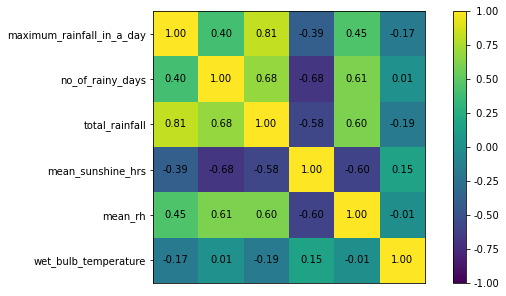

In [4]:
# Plot correlation matrix of the dataframe
corr = df_rain.iloc[:,:6].corr()
fig, ax = plt.subplots(figsize = (10,5))
im = ax.imshow(corr)
im.set_clim(-1,1)
ax.xaxis.set(ticks = (), ticklabels = ())
ax.yaxis.set(ticks = np.arange(0,6), ticklabels = corr.columns)
for i in range(6):
    for j in range(6):
        ax.text(i,j, "{:.2f}".format(corr.iloc[i,j]), ha = 'center', va = 'center', color = 'k')
cbar = ax.figure.colorbar(im, ax=ax, format ='% .2f')

From the above, we can see that other than wet bulb temperature, all the other features clearly exhibit either a positive or negative with one another. Moving on we shall focus on the monthly number of rainy days and the monthly total rainfall for analysis, starting with a simple plot of their averages.

Text(0, 0.5, 'Monthly total rainfall')

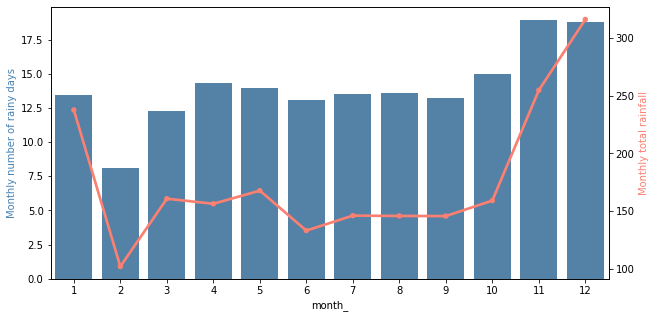

In [5]:
# Plot histogram of average rainy days / rainfall per month
fig, ax = plt.subplots(figsize = (10,5))
ax2 = ax.twinx()
sns.barplot(x = df_rain.groupby(df_rain['month_']).mean()['no_of_rainy_days'].index, y = df_rain.groupby(df_rain['month_']).mean()['no_of_rainy_days'], ax = ax, color = 'steelblue')
sns.pointplot(x = df_rain.groupby(df_rain['month_']).mean()['total_rainfall'].index, y = df_rain.groupby(df_rain['month_']).mean()['total_rainfall'], ax = ax2, markers = '.', color = 'salmon')
ax.set_ylabel('Monthly number of rainy days', color = 'steelblue')
ax2.set_ylabel('Monthly total rainfall', color = 'salmon')

Looking at the average number of rainy days and average monthly total rainfall between Jan 1982 to May 2021 we observe that there appears to be a distinct wet and dry period. An alternative way to visualise the data would be using a boxplot to show how plotting all the data points would look, compared to plotting just the averages.

Text(0, 0.5, 'Monthly Number of Rainy Days')

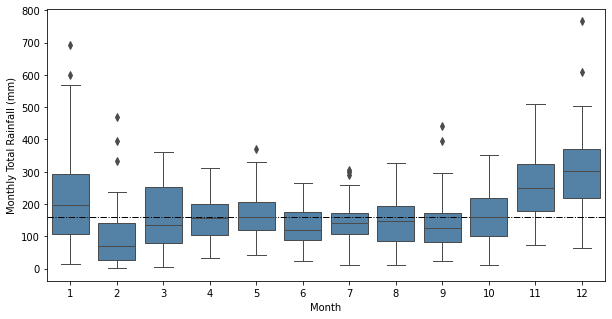

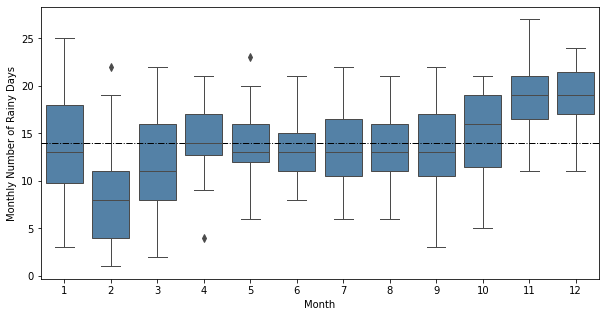

In [6]:
# Plot box plot of total rainfall
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x = df_rain['month_'], y = df_rain['total_rainfall'], ax = ax, color = 'steelblue', linewidth = 1)
ax.axhline(df_rain['total_rainfall'].median(), color = 'black', ls = '-.', lw = 1)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Rainfall (mm)')

# Plot box plot of number of rainy days
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x = df_rain['month_'], y = df_rain['no_of_rainy_days'], ax = ax, color = 'steelblue', linewidth = 1)
ax.axhline(df_rain['no_of_rainy_days'].median(), color = 'black', ls = '-.', lw = 1)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Number of Rainy Days')

From the two box plots we observe that the data once again suggests that dry and wet periods are present throughout the year, notably February being a dry month with most of the data points lying way below the yearly median. November and December are the wettest months with most of their data points lying way above the yearly median.<br><br>

Using seasonal_decompose from statsmodels library, we can decompose the data to show their trends, seasonal patterns, and residuals.

Text(0.5, 0.98, 'Monthly Number of Rainy Days')

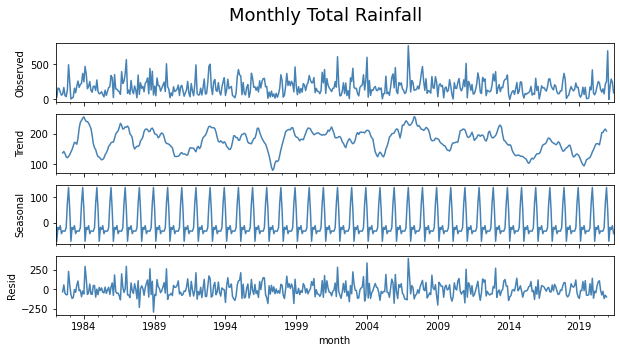

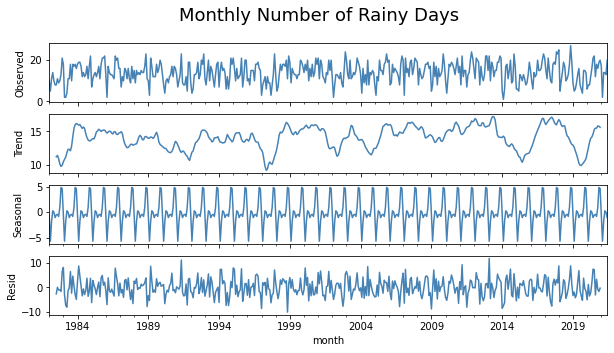

In [7]:
# Seasonal decompose
result = seasonal_decompose(df_rain['total_rainfall'],  model = 'additive', period = 12)
fig, ax = plt.subplots(4,1, sharex = True, figsize = (10,5))
result.observed.plot(ax=ax[0], legend = False, color = 'steelblue')
ax[0].set_ylabel('Observed')
result.trend.plot(ax=ax[1], legend = False, color = 'steelblue')
ax[1].set_ylabel('Trend')
result.seasonal.plot(ax=ax[2], legend = False, color = 'steelblue')
ax[2].set_ylabel('Seasonal')
result.resid.plot(ax=ax[3], legend = False, color = 'steelblue')
ax[3].set_ylabel('Resid')
fig.suptitle('Monthly Total Rainfall', fontsize = 18)

result = seasonal_decompose(df_rain['no_of_rainy_days'], model = 'additive', period = 12)
fig, ax = plt.subplots(4,1, sharex = True, figsize = (10,5))
result.observed.plot(ax=ax[0], legend = False, color = 'steelblue')
ax[0].set_ylabel('Observed')
result.trend.plot(ax=ax[1], legend = False, color = 'steelblue')
ax[1].set_ylabel('Trend')
result.seasonal.plot(ax=ax[2], legend = False, color = 'steelblue')
ax[2].set_ylabel('Seasonal')
result.resid.plot(ax=ax[3], legend = False, color = 'steelblue')
ax[3].set_ylabel('Resid')
fig.suptitle('Monthly Number of Rainy Days', fontsize = 18)

From the decompositions above, we can see that there is no discernable trends for either feature, with strong seasonal patterns for both.

***

<a id = '2.3'></a>
#### 2.3. ARIMA Forecasting
Now, we shall build an ARIMA model to forecast monthly total rainfall. First we will split the dataset into a training, a validation, and a test set.

In [8]:
# Training set; data from start 1982 to end 2015
training_set = df_rain[:'2015-12-31 00:00:00']

# Validation set; data from start 2016 to end 2017
validation_set = df_rain['2016-01-01 00:00:00':'2017-12-31 00:00:00']

# Test set; data from start 2018 to end 2020
test_set = df_rain['2018-01-01 00:00:00':'2019-12-31']

When building an ARIMA model we will have to specify several parameters:
* **p**: The number of lag observations the model will use
* **d**: The number of times that the raw observations are differenced before stationarity
* **q**: The size of the moving average window

In addition, as we are working with seasonal data, our ARIMA model will actually be a SARIMa model with additional parameters:
* **P**: The number of seasonal lag observations the model will use
* **D**: The number of times that the seasonal observations are differenced before stationarity
* **Q**: The size of the seasonal moving average window
* **m**: The number of observations in one season

**d** and **D** parameters shall first be determined by using the Augmented Dickey–Fuller test to test for stationarity.

In [9]:
# Test training set for stationarity
result = adfuller(training_set['total_rainfall'])
print(dict(zip(['adf','pvalue','usedlag','nobs','critical','values','icbest'],result))) # pvalue < 0.05, stationary

training_set['seasonal'] = training_set['total_rainfall']-training_set['total_rainfall'].shift(12) # Seasonal period of 12 months
result = adfuller(training_set['seasonal'].dropna()) # dropna as first 12 years have no previous years to difference from
print(dict(zip(['adf','pvalue','usedlag','nobs','critical','values','icbest'],result))) # pvalue < 0.05, stationary

{'adf': -5.2653462999033955, 'pvalue': 6.457147531182888e-06, 'usedlag': 14, 'nobs': 393, 'critical': {'1%': -3.447099431978147, '5%': -2.8689225261604263, '10%': -2.57070269105012}, 'values': 4772.721419029585}
{'adf': -7.501283287333318, 'pvalue': 4.2469967207594814e-11, 'usedlag': 14, 'nobs': 381, 'critical': {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 'values': 4721.95987908436}


As the p-values for both tests conducted above are below 0.05, the data tested are stationary. As no additional differencing was required for the original data and seasonal data to achieve stationarity, **d** and **D** are determined to be 0.<br><br>
Next, **p**, **q**, **P**, and **Q** parameters will be determined by using autocorrelation and partial autocorrelation plots.

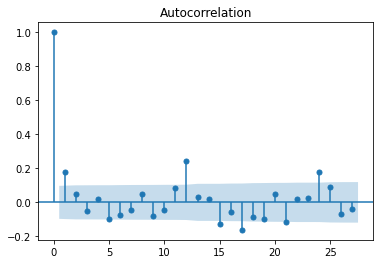

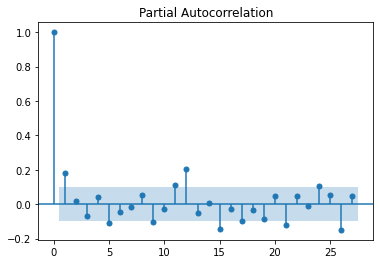

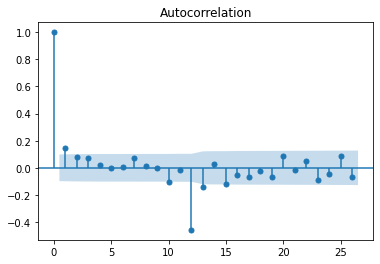

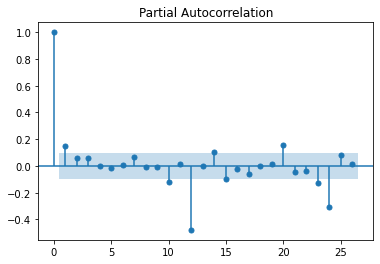

In [10]:
# Plotting ACF PACF
fig1 = plot_acf(training_set['total_rainfall']) # MA(1) , q = 1
fig2 = plot_pacf(training_set['total_rainfall']) # AR(1) , p = 1

fig3 = plot_acf(training_set['seasonal'].dropna()) # MA(1) , Q = 1
fig4 = plot_pacf(training_set['seasonal'].dropna()) # AR(1) , P = 1

From above, we observe sharp drop off after lag 1, suggesting a value of 1 for all four parameters. This gives us a final parameter setting of (1,0,1)(1,0,1,12). However, to be more thorough in our testing, we shall test build and compare models using the neighbouring parameters to find the best performing one.

In [11]:
# Parameters to test
models = []
models.append([(1,0,1),(1,0,1,12)])
models.append([(0,0,1),(0,0,1,12)])
models.append([(1,0,0),(1,0,0,12)])
models.append([(2,0,1),(2,0,1,12)])
models.append([(1,0,2),(1,0,2,12)])
models.append([(2,0,2),(2,0,2,12)])

# Dataframe to contain predictions
valid_dates = [training_set.index[-1]+DateOffset(months=x) for x in range(1,25)]
df_pred = pd.DataFrame(index = valid_dates, columns = training_set.columns)
df_pred = pd.concat([training_set,df_pred])
mse = []

# Train and compare performance of all models
for m in models:
    model = SARIMAX(training_set['total_rainfall'], order = m[0], seasonal_order = m[1])
    try:
        result = model.fit()
    except:
        pass
    df_pred['predictions'] = result.predict(start = 408, end = 432)
    print('Model parameter:', m)
    print('RMSE: ', mean_squared_error(validation_set['total_rainfall'], df_pred['predictions'][408:432], squared = False))
    mse.append((m, mean_squared_error(validation_set['total_rainfall'], df_pred['predictions'][408:432], squared = False)))
    # 2,0,2 best parameter

Model parameter: [(1, 0, 1), (1, 0, 1, 12)]
RMSE:  57.30815781522598
Model parameter: [(0, 0, 1), (0, 0, 1, 12)]
RMSE:  164.47799116349768
Model parameter: [(1, 0, 0), (1, 0, 0, 12)]
RMSE:  134.48210428696984
Model parameter: [(2, 0, 1), (2, 0, 1, 12)]
RMSE:  134.48210428696984
Model parameter: [(1, 0, 2), (1, 0, 2, 12)]
RMSE:  57.01480343641966
Model parameter: [(2, 0, 2), (2, 0, 2, 12)]
RMSE:  54.546991581555375


We shall use (2,0,2)(2,0,2,12) as the parameters for our model as it has the lowest RMSE.

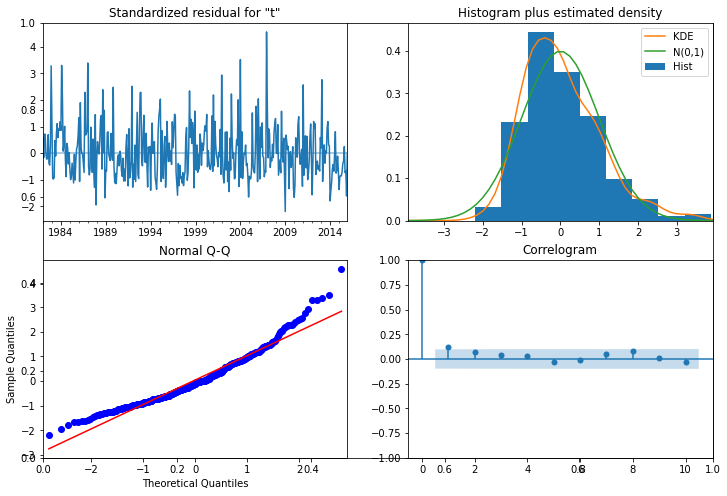

In [12]:
# Test residuals 
model = SARIMAX(training_set['total_rainfall'], order = (2,0,2), seasonal_order = (2,0,2,12))
result = model.fit()
fig5, ax = plt.subplots(figsize = (12,8))
result.plot_diagnostics(fig = fig5, figsize = (10,5))
fig5.show()     

The above plots tell us that residual appears to fluctuate around zero with uniform variance, density plot suggests normal distributions with a mean of zero, the points in the Q-Q plot fits the line and the ACF plot shows that residual errors are not autocorrelated, suggesting a good model.

Visualising the forecasted rainfal on validation set.

RMSE (ARIMA, validation):  54.546991581555375


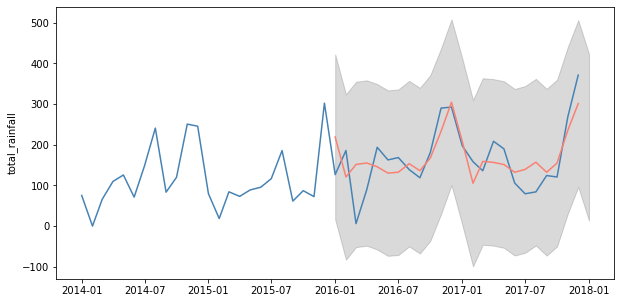

In [13]:
# Predictions
df_pred['arima_v'] = result.predict(start = 408, end = 432)
arima_v = df_pred['arima_v'][408:]

nforecast = 24
forecast = result.get_prediction(end=model.nobs + nforecast)
ci = forecast.conf_int()

print('RMSE (ARIMA, validation): ', mean_squared_error(df_rain['total_rainfall'][408:432], df_pred['arima_v'][408:432], squared = False))
# Plot data
fig, ax = plt.subplots(figsize = (10,5))
sns.lineplot(x = df_pred.index[384:], y = df_rain['total_rainfall'][384:432], ax = ax, color = 'steelblue')
sns.lineplot(x = df_pred.index[408:], y = df_pred['arima_v'][408:], ax = ax, color = 'salmon')
ax.fill_between(ci.index[408:], ci['lower total_rainfall'][408:], ci['upper total_rainfall'][408:], color = 'k', alpha = .15)

The SARIMA model appears to capture the seasonal patterns well, most notable difference from reality being the magnitude of the total rainfall in Feb 2016.

Now we shall retrain the model using the same parameters, but on both the training and validation data, while testing the new model on the test data.

RMSE (ARIMA, test):  91.99399811290013


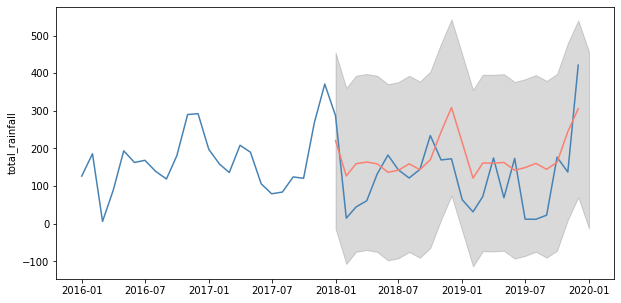

In [14]:
# Forecast test set
final_training_set = pd.concat([training_set, validation_set])
test_dates = [final_training_set.index[-1]+DateOffset(months = x) for x in range(1,25)]
df_pred = pd.DataFrame(index = test_dates, columns = final_training_set.columns)
df_pred = pd.concat([final_training_set, df_pred])

# ARIMA
model = SARIMAX(final_training_set['total_rainfall'], order = (2,0,2), seasonal_order = (2,0,2,12))
result = model.fit()
df_pred['arima_t'] = result.predict(start = 432, end = 456)
arima_t = df_pred['arima_t'] = result.predict(start = 432, end = 456)

forecast = result.get_prediction(end = model.nobs + nforecast)
ci = forecast.conf_int()

# Error
print('RMSE (ARIMA, test): ' , mean_squared_error(test_set['total_rainfall'], df_pred['arima_t'][432:], squared = False))

# Plot
fig, ax = plt.subplots(figsize = (10,5))
sns.lineplot(x = df_pred.index[408:], y = df_rain['total_rainfall'][408:456], ax = ax, color = 'steelblue')
sns.lineplot(x = df_pred.index[432:], y = df_pred['arima_t'][432:], ax = ax, color = 'salmon')
ax.fill_between(ci.index[432:], ci['lower total_rainfall'][432:], ci['upper total_rainfall'][432:], color = 'k', alpha = .15)

We observe that the RMSE for test set has increase significantly. Looking at the predictions, we can see that the model has failed to predict the dry seasons within these two years. Especially in 2019, Jun, Jul, and Aug appears to be abnormally dry months with less than 25mm of total rainfall each. These are scenarios which the model cannot foresee.

***

<a id='2.4'></a>
#### 2.4. ETS Forecast
Exponential Smoothing (ETS) is another popular method of forecasting, with a very similar method of application using the statsmodels library.

RMSE (ETS, validation):  61.97478033465701


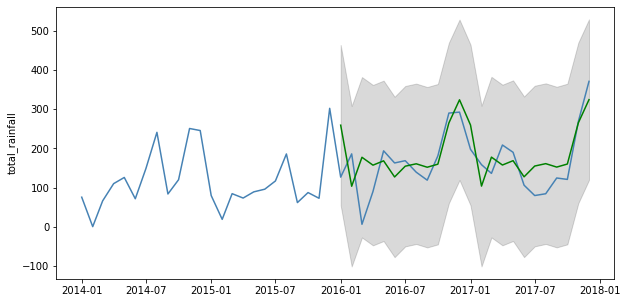

In [15]:
# ETS
model = ETSModel(training_set['total_rainfall'], error = 'add', trend = 'add', seasonal = 'add', seasonal_periods = 12)
result = model.fit()

result.summary()
pred = result.get_prediction(start = 408, end = 432)
df_ets_v = pred.summary_frame(alpha = 0.05)

print('RMSE (ETS, validation): ', mean_squared_error(df_rain['total_rainfall'][408:432], df_ets_v['mean'][:-1], squared = False))
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = df_pred.index[384:432], y = df_rain['total_rainfall'][384:432], ax = ax, color = 'steelblue')
sns.lineplot(x = df_pred.index[408:432], y = df_ets_v['mean'][:-1], ax = ax, color = 'green')
ax.fill_between(df_ets_v.index[:-1], df_ets_v['pi_lower'][:-1], df_ets_v['pi_upper'][:-1], color = 'k', alpha = .15)

Looking at the results we observe similar predictions between the ARIMA model and the ETS model, with ARIMA outperforming ETS slightly when forecasting the validation set.

Now we shall forecast the test set with ETS.

RMSE (ETS, test):  92.70610652102692


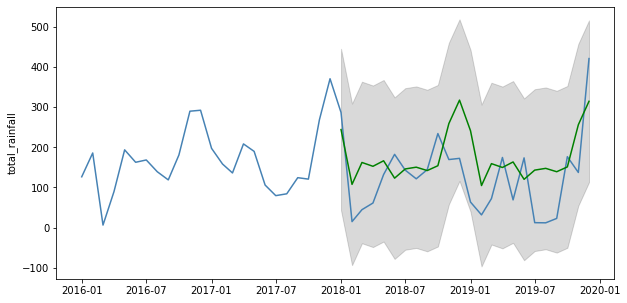

In [16]:
# ETS
model = ETSModel(final_training_set['total_rainfall'], error = 'add', trend = 'add', seasonal = 'add', seasonal_periods = 12)
result = model.fit()

pred = result.get_prediction(start = 432, end = 456)
df_ets_t = pred.summary_frame(alpha = 0.05)

#Error
print('RMSE (ETS, test): ' , mean_squared_error(test_set['total_rainfall'], df_ets_t['mean'][:-1], squared = False))

# Plot
fig, ax = plt.subplots(figsize = (10,5))
sns.lineplot(x = df_pred.index[408:], y = df_rain['total_rainfall'][408:456], ax = ax, color = 'steelblue')
sns.lineplot(x = df_pred.index[432:], y = df_ets_t['mean'][:-1], ax = ax, color = 'green')
ax.fill_between(df_ets_t.index[:-1], df_ets_t['pi_lower'][:-1], df_ets_t['pi_upper'][:-1], color = 'k', alpha = .15)

Similar to the ARIMA model, the ETS model was not able to foresee the abormally dry period on 2019, resulting in an increase in RMSE. when comparing the two models, ARIMA was able to outperform ETS slightly when forecasting the test set.

***

<a id='2.5'></a>
####  2.5. LASSO Regression Forecast
Now, we shall build a LASSO Regression model using sklearn to forecast monthly rainfall. Below is a function written to conduct walk forward cross validation while testing different parameter settings for the LASSO model. While ARIMA and ETS models used only the monthly total rainfall data, LASSO model will utilise all the features we saw in Section 2.2.

Text(0, 0.5, 'RMSE')

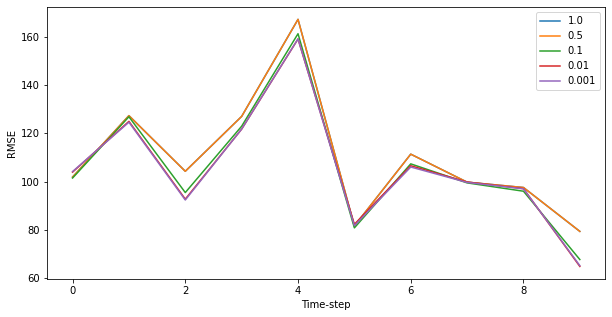

In [17]:
# Gridsearch + CV
params = [1,0.5,0.1,0.01,0.001]
scaler = StandardScaler()

# Function for time series cv
def timecv(algo, df, end, step, params, n):
    df_cv = df[['maximum_rainfall_in_a_day','no_of_rainy_days','total_rainfall',
       'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']]
    lasso_total_evaluation = []
    
    for i in range(n,0,-1):
        lasso_evaluation = []
        x_train = scaler.fit_transform(df_cv[:end-(i*step)-1])
        y_train = scaler.fit_transform(df_cv[1:end-(i*step)]['total_rainfall'].values.reshape(-1,1))
        
        x_test = scaler.fit_transform(df_cv[end-(i*step)-1 : end-((i-1)*step)-1])
        y_test = df_cv[end-(i*step) : end-((i-1)*step)]['total_rainfall'].values.reshape(-1,1)
        original_y_test = y_test.copy()
        y_test = scaler.fit_transform(df_cv[1:end-((i-1)*step)]['total_rainfall'].values.reshape(-1,1))
        for p in params:
            lasso = algo(alpha = p)
            lasso.fit(x_train,y_train)
            #print('alpha = ', p)
            pred = lasso.predict(x_test)
            pred = scaler.inverse_transform(pred.reshape(-1,1))
            
            rmse = mean_squared_error(original_y_test, pred, squared = False)
            r2 = r2_score(original_y_test, pred)
            #print('Lasso RMSE : ', rmse) 
            #print('Lasso R2 : ', r2)
            
            lasso_evaluation.append((p, rmse, r2))
        lasso_total_evaluation.append(lasso_evaluation)
    return lasso_total_evaluation, original_y_test

# 432 is the final index of validation data, test data is not used while tuning model      
lasso_total_evaluation, original_y_test = timecv(Lasso, df_rain, 432, 24, params, 10) 
lasso_total_evaluation = np.array(lasso_total_evaluation).transpose()[1]
lasso_total_evaluation = pd.DataFrame(lasso_total_evaluation.transpose())

lasso_total_evaluation.columns = params

fig, ax = plt.subplots(figsize = (10,5))
lasso_total_evaluation.plot(ax = ax)
ax.set_xlabel('Time-step')
ax.set_ylabel('RMSE')

In [18]:
lasso_total_evaluation

,1.000,0.500,0.100,0.010,0.001
0,101.849603,101.849603,101.450217,103.883366,104.135048
1,127.308776,127.308776,126.847787,124.947113,124.593454
2,104.244109,104.244109,95.426630,92.701373,92.343451
3,126.992281,126.992281,122.930469,121.723263,121.736685
4,167.228672,167.228672,161.271326,159.081613,159.152004
5,81.551657,81.551657,80.777737,82.259223,81.688308
6,111.342802,111.342802,107.317591,106.538594,106.010173
7,99.733972,99.733972,99.429571,99.793862,99.617501
8,97.516008,97.516008,95.975590,97.058428,96.963188
9,79.323269,79.323269,67.650084,64.788869,65.126505


RMSE (LASSO, validation):  66.94608699967773
RMSE (LASSO, test):  93.79511896924599


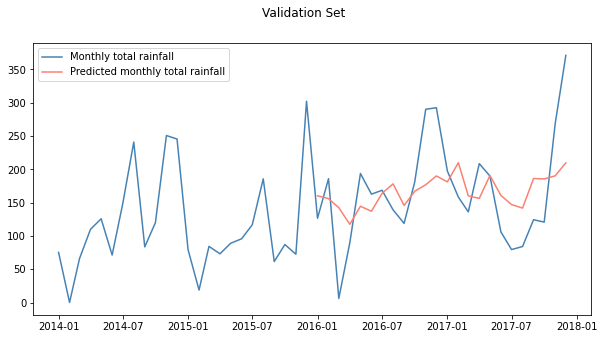

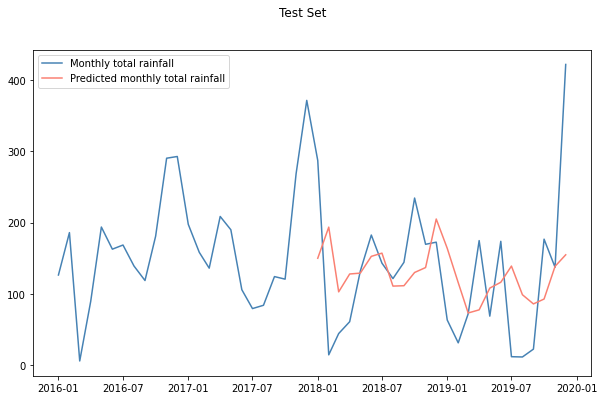

In [19]:
# Forecasting validation set
x_train = training_set[['maximum_rainfall_in_a_day','no_of_rainy_days', 'total_rainfall',
       'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']][:-1]

y_train = training_set['total_rainfall'][1:]
x_train = scaler.fit_transform(x_train)

x_test = pd.concat([training_set[['maximum_rainfall_in_a_day','no_of_rainy_days', 'total_rainfall',
       'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']][-1:],
                    validation_set[['maximum_rainfall_in_a_day','no_of_rainy_days', 'total_rainfall',
       'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']][:-1]])

y_test = validation_set['total_rainfall']
x_test = scaler.fit_transform(x_test)
backup = y_test.copy()
y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = scaler.fit_transform(y_test.values.reshape(-1,1))

lasso = Lasso(alpha = 0.001)
lasso.fit(x_train, y_train)
lasso.score(x_test, y_test),lasso.score(x_train, y_train)
pred = lasso.predict(x_test)
lasso_v = scaler.inverse_transform(pred.reshape(-1,1))[:,0]

# Error
print('RMSE (LASSO, validation): ', mean_squared_error(backup, scaler.inverse_transform(pred.reshape(-1,1)), squared = False))

# Plot
fig, ax = plt.subplots(figsize = (10,5))
fig.suptitle('Validation Set')
ax.plot(df_pred.index[384:432], df_rain['total_rainfall'][384:432],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[408:432], lasso_v, color = 'salmon', label = 'Predicted monthly total rainfall')
ax.legend()



# Forecasting test set
x_train = pd.concat([training_set, validation_set])
y_train = x_train['total_rainfall'][1:]
x_train = x_train[['maximum_rainfall_in_a_day','no_of_rainy_days', 'total_rainfall',
       'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']][:-1]

x_test = pd.concat([validation_set[['maximum_rainfall_in_a_day','no_of_rainy_days', 'total_rainfall',
       'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']][-1:],
                    test_set[['maximum_rainfall_in_a_day','no_of_rainy_days', 'total_rainfall',
       'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']][:-1]])
y_test = test_set['total_rainfall']

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
backup = y_test.copy()
y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = scaler.fit_transform(y_test.values.reshape(-1,1))


lasso = Lasso(alpha = 0.001)
lasso.fit(x_train, y_train)
lasso.score(x_test, y_test),lasso.score(x_train, y_train)
pred = lasso.predict(x_test)
lasso_t = scaler.inverse_transform(pred.reshape(-1,1))[:,0]

# Error
print('RMSE (LASSO, test): ', mean_squared_error(backup, scaler.inverse_transform(pred.reshape(-1,1)), squared = False))

# Plot
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Test Set')
ax.plot(df_pred.index[408:456],df_rain['total_rainfall'][408:456],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[432:456],lasso_t,color = 'salmon', label = 'Predicted monthly total rainfall')
ax.legend()

We can see that compared to the ARIMA and ETS models, the LASSO model has a slightly higher RMSE. When forecasting for the validation set, the LASSO model predict the magnitude of fluctuations in monthly total rainfall poorly leading to a higher error. When forecasting test set however, the changes in magnitude of predictions appear to be better than the ARIMA and ETS models. However, the LASSO model incorrectly predicted the timing of these changes leading to a larger RMSE.

***

<a id ='2.6'></a>
#### 2.6. Neural Network Forecast
Lastly, we are going to build a relatively simple neural network model to forecast monthly rainfall, and see how the different models compare. The model will forecast a single step into the future.

Epoch 1/50
87/87 [==============================] - 21s 12ms/step - loss: 1.8338
Epoch 2/50
87/87 [==============================] - 1s 13ms/step - loss: 1.7970
Epoch 3/50
87/87 [==============================] - 1s 12ms/step - loss: 1.1382
Epoch 4/50
87/87 [==============================] - 1s 12ms/step - loss: 1.2597
Epoch 5/50
87/87 [==============================] - 1s 10ms/step - loss: 1.9075
Epoch 6/50
87/87 [==============================] - 1s 10ms/step - loss: 1.2395
Epoch 7/50
87/87 [==============================] - 1s 10ms/step - loss: 1.6503
Epoch 8/50
87/87 [==============================] - 1s 12ms/step - loss: 1.3419: 0s - loss: 1.
Epoch 9/50
87/87 [==============================] - 1s 11ms/step - loss: 1.2355
Epoch 10/50
87/87 [==============================] - 1s 10ms/step - loss: 1.0882
Epoch 11/50
87/87 [==============================] - 1s 10ms/step - loss: 0.7265
Epoch 12/50
87/87 [==============================] - 1s 10ms/step - loss: 1.3517
Epoch 13/50
87/87 [==

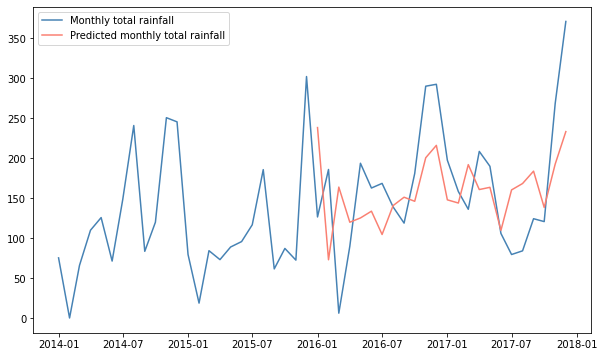

In [20]:
TRAINING_DATE = 408
VALIDATION_DATE = 432
TEST_DATE = 456
WINDOW_SIZE = 60

# Funcction to create x and y data sets
def create_x_y(dataset, WINDOW_SIZE):
    x, y = [], []
    for i in range(WINDOW_SIZE, len(dataset)):
        x.append(dataset[i-WINDOW_SIZE:i][['maximum_rainfall_in_a_day','no_of_rainy_days', 'total_rainfall', 'mean_sunshine_hrs', 'mean_rh', 'wet_bulb_temperature']])
        #y.append(dataset.iloc[i]['total_rainfall'])
        y.append(dataset.iloc[i][['maximum_rainfall_in_a_day','no_of_rainy_days','total_rainfall','mean_sunshine_hrs','mean_rh','wet_bulb_temperature']])
    x, y = np.array(x), np.array(y)
    return x, y

# Function to window normalize data set
def normalize_window(x, y):
    x_norm = x.copy()
    y_norm = y.copy()
    
    for i in range(x_norm.shape[0]):
        #y_norm[i] = (y[i]/x[i][0][1])-1
        y_norm[i][:6] = (y[i][:6]/x[i][0][:6])-1
        for j in range(x_norm.shape[1]):
            x_norm[i][j][:6] = (x[i][j][:6]/x[i][0][:6])-1 # normalize all input data within window with respect to the first value 
    return x_norm, y_norm

# Function to reverse normalization after prediciton
def denormalize(x_test, prediction):
    y_denorm = prediction.copy()
    for i in range(x_test.shape[0]):
        #y_denorm[i] = x_test[i][0][1]*(prediction[i]+1)
        y_denorm[i][:6] = x_test[i][0][:6]*(prediction[i][:6] + 1)
    return y_denorm

# Validation (Single step prediciton)
x_train, y_train = create_x_y(training_set, WINDOW_SIZE)
x_norm_train, y_norm_train = normalize_window(x_train, y_train)

model = Sequential()

model.add(LSTM(units = 32, return_sequences = True, input_shape = (x_train.shape[1], 6)))
model.add(Dropout(0.2))

model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 32))
model.add(Dropout(0.2))

model.add(Dense(units = 6))

opt = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'mean_squared_error')

model.fit(x_norm_train, y_norm_train, epochs = 50, batch_size = 4)

x_ = pd.concat([training_set, validation_set])
x_valid , y_valid = create_x_y(x_, WINDOW_SIZE)
x_valid = x_valid[TRAINING_DATE-WINDOW_SIZE:]
y_valid = y_valid[TRAINING_DATE-WINDOW_SIZE:]

x_norm_valid, _ = normalize_window(x_valid, y_valid)
prediction = model.predict(x_norm_valid)

prediction = denormalize(x_valid, prediction)

# Error
print('RMSE (LSTM, validation): ', mean_squared_error(y_valid[:,2], prediction[:,2], squared = False))

# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(df_pred.index[TRAINING_DATE-24:VALIDATION_DATE],df_rain['total_rainfall'][TRAINING_DATE-24:VALIDATION_DATE],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[VALIDATION_DATE-24:VALIDATION_DATE],prediction[:,2],color = 'salmon', label = 'Predicted monthly total rainfall')
ax.legend()

RMSE (LSTM, test):  92.71514044613075


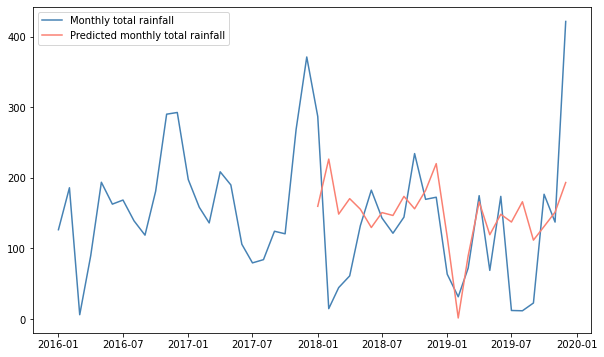

In [21]:
# Test (Single step prediction)
x_train, y_train = create_x_y(x_, WINDOW_SIZE)
x_norm_train, y_norm_train = normalize_window(x_train, y_train)

#model.fit(x_norm_train, y_norm_train, epochs = 150, batch_size = 4)

#x_ = pd.concat([training_set, validation_set])
x_ = pd.concat([x_, test_set])
x_test, y_test = create_x_y(x_, WINDOW_SIZE)
x_test = x_test[VALIDATION_DATE-WINDOW_SIZE:]
y_test = y_test[VALIDATION_DATE-WINDOW_SIZE:]

x_norm_test, _ = normalize_window(x_test, y_test)
prediction = model.predict(x_norm_test)

prediction = denormalize(x_test, prediction)

print('RMSE (LSTM, test): ', mean_squared_error(y_test[:,2], prediction[:,2], squared = False))

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(df_pred.index[TRAINING_DATE:TEST_DATE], df_rain['total_rainfall'][TRAINING_DATE:TEST_DATE],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[VALIDATION_DATE:TEST_DATE], prediction[:,2],color = 'salmon', label = 'Predicted monthly total rainfall')
ax.legend()

Like all the other models, the LSTM model appears to be able to capture the seasonal patterns of the rainfall in general, but exhibits difficulty in accurately forecasting the magnitude and timing of large swings in monthly rainfall. 

When forecasting the validation set, the LSTM correctly predicted the number of crests and troughs in rainfall data in the two years, but slight errors in magnitude and timing of the predictions resulted in a higher RMSE compared to the other models.
When forecasting the test set LSTM model was unable to predict the abnormally dry Jun-Aug period in 2019 as wll.

To convert the single step predictions into multi step predictions, we can feed the predictions at each step back into the training data for the next set, repeating this action for the number of time steps to predict.

RMSE (LSTM, validation):  104.3868600820836
RMSE (LSTM, test):  97.50155528419486


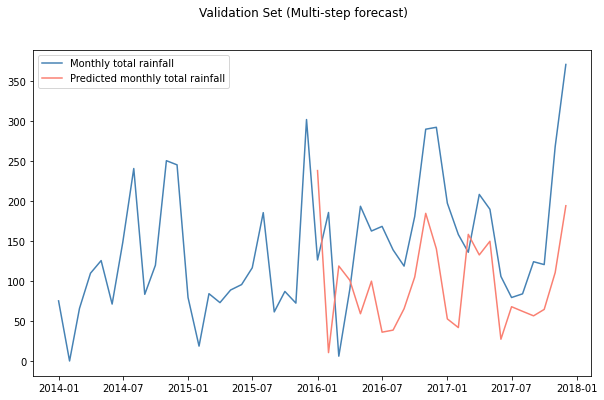

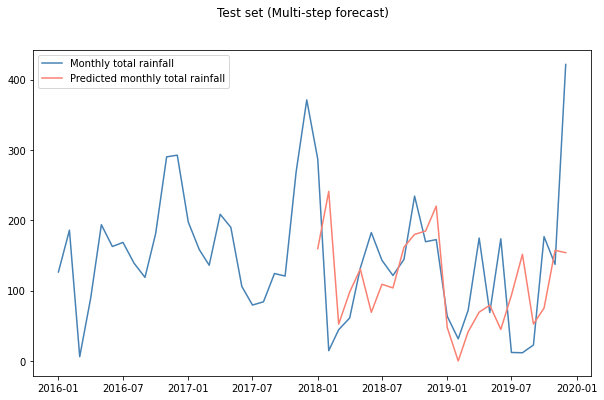

In [22]:
# Validation (Multi step prediciton)
x_train, y_train = create_x_y(training_set, WINDOW_SIZE)
x_norm_train, y_norm_train = normalize_window(x_train, y_train)
x_ = pd.concat([training_set, validation_set])
x_valid , y_valid = create_x_y(x_, WINDOW_SIZE)
x_valid = x_valid[TRAINING_DATE-WINDOW_SIZE:]
y_valid = y_valid[TRAINING_DATE-WINDOW_SIZE:]

x_norm_valid, _ = normalize_window(x_valid, y_valid)
x_norm_valid = x_norm_valid[0]
x_norm_valid = np.reshape(x_norm_valid, (1, x_norm_valid.shape[0], x_norm_valid.shape[1]))

prediction_valid = []
x_valid_list = []
for i in range(x_valid.shape[0]):
    x_valid_list.append(x_norm_valid[0])
    prediction = model.predict(x_norm_valid)
    prediction_valid.append(prediction[0])
    x_norm_valid = x_norm_valid[0][1:]
    x_norm_valid = np.append(x_norm_valid, prediction, axis = 0)
    x_norm_valid = np.reshape(x_norm_valid, (1, x_norm_valid.shape[0], x_norm_valid.shape[1]))
    #print(x_norm_valid.shape)

x_valid_list, prediction_valid = np.array(x_valid_list), np.array(prediction_valid)
lstm_v = denormalize(x_valid, prediction_valid)


# Error
print('RMSE (LSTM, validation): ', mean_squared_error(y_valid[:,2], lstm_v[:,2], squared = False))

# Plot
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Validation Set (Multi-step forecast)')
ax.plot(df_pred.index[TRAINING_DATE-24:VALIDATION_DATE],df_rain['total_rainfall'][TRAINING_DATE-24:VALIDATION_DATE],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[TRAINING_DATE:VALIDATION_DATE],lstm_v[:,2],color = 'salmon', label = 'Predicted monthly total rainfall')
ax.legend()


# Test (Multi step prediction)
x_ = pd.concat([x_, test_set])
x_test, y_test = create_x_y(x_, WINDOW_SIZE)
x_test = x_test[VALIDATION_DATE-WINDOW_SIZE:]
y_test = y_test[VALIDATION_DATE-WINDOW_SIZE:]

x_norm_test, _ = normalize_window(x_test, y_test)
x_norm_test = x_norm_test[0]
x_norm_test = np.reshape(x_norm_test, (1, x_norm_test.shape[0], x_norm_test.shape[1]))

prediction_test = []
x_test_list = []
for i in range(x_test.shape[0]):
    x_test_list.append(x_norm_test[0])
    prediction = model.predict(x_norm_test)
    prediction_test.append(prediction[0])
    x_norm_test = x_norm_test[0][1:]
    x_norm_test = np.append(x_norm_test, prediction, axis = 0)
    x_norm_test = np.reshape(x_norm_test, (1, x_norm_test.shape[0], x_norm_test.shape[1]))
    #print(x_norm_test.shape)
    
x_test_list, prediction_test = np.array(x_test_list), np.array(prediction_test)
lstm_t = denormalize(x_test, prediction_test)

# Error
print('RMSE (LSTM, test): ', mean_squared_error(y_test[:,2], lstm_t[:,2], squared = False))

# Plot
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Test set (Multi-step forecast)')
ax.plot(df_pred.index[TRAINING_DATE:TEST_DATE], df_rain['total_rainfall'][TRAINING_DATE:TEST_DATE],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[VALIDATION_DATE:TEST_DATE], lstm_t[:,2],color = 'salmon', label = 'Predicted monthly total rainfall')
ax.legend()

When converting to a multi-step forecast, the RMSE of the model significantly increases when forecasting the validation data. However, something to note is that the prediction of dry and wet months are still similar to that of single-step predictions, and the increase in RMSE is mainly due to the magnitudes of predictions for multi-step forecast being less accurate.

When forecasting the test set, the RMSE of single-step and multi-step forecasts are very similar. In the multi-step forecast the predictions for 2018 are significantly more accurate, while in 2019 a wet period was predicted during the abnormally dry months resulting in a comparatively higher RMSE than single-step forecast.

<br><br>
All the predictions and the actual values are plotted below to visualise the comparison between the models.

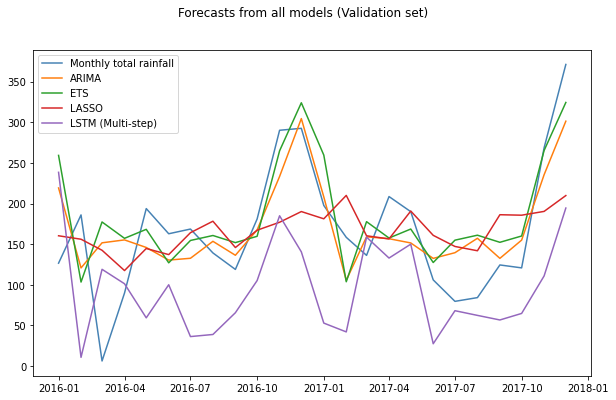

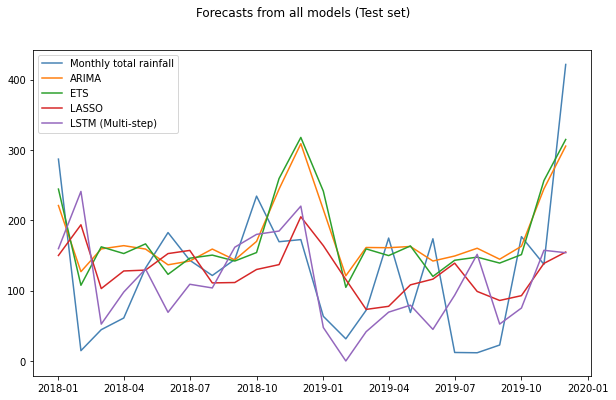

In [23]:
# Plot all forecasts for validation set
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Forecasts from all models (Validation set)')
ax.plot(df_pred.index[TRAINING_DATE:VALIDATION_DATE], df_rain['total_rainfall'][TRAINING_DATE:VALIDATION_DATE],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[TRAINING_DATE:VALIDATION_DATE], arima_v,color = 'tab:orange', label = 'ARIMA')
ax.plot(df_pred.index[TRAINING_DATE:VALIDATION_DATE], df_ets_v['mean'][:-1],color = 'tab:green', label = 'ETS')
ax.plot(df_pred.index[TRAINING_DATE:VALIDATION_DATE], lasso_v,color = 'tab:red', label = 'LASSO')
ax.plot(df_pred.index[TRAINING_DATE:VALIDATION_DATE], lstm_v[:,2],color = 'tab:purple', label = 'LSTM (Multi-step)')
ax.legend()

# Plot all forecast for test set
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Forecasts from all models (Test set)')
ax.plot(df_pred.index[VALIDATION_DATE:TEST_DATE], df_rain['total_rainfall'][VALIDATION_DATE:TEST_DATE],color = 'steelblue', label = 'Monthly total rainfall')
ax.plot(df_pred.index[VALIDATION_DATE:TEST_DATE], arima_t[:-1],color = 'tab:orange', label = 'ARIMA')
ax.plot(df_pred.index[VALIDATION_DATE:TEST_DATE], df_ets_t['mean'][:-1],color = 'tab:green', label = 'ETS')
ax.plot(df_pred.index[VALIDATION_DATE:TEST_DATE], lasso_t,color = 'tab:red', label = 'LASSO')
ax.plot(df_pred.index[VALIDATION_DATE:TEST_DATE], lstm_t[:,2],color = 'tab:purple', label = 'LSTM (Multi-step)')
ax.legend()

***
<a id = '3.1'></a>
### 3. Daily Rainfall Recorded at Various Weather Stations Around Singapore
#### 3.1. Data
In this section we shall look at the daily rainfall data collected around Singapore. The relevant data sets were downloaded from [weather.gov.sg](https://www.weather.gov.sg/climate-historical-daily/) using a [python script](https://github.com/wenhao7/Data-Science/blob/main/Rainfall%20in%20Singapore/download_weather_gov.py) and combined to form a single data set for ease of use.

Several stations were chosen from the stations available, with the goal of having enough data from stations all over Singapore to properly map out the daily rainfall patterns at different regions of Singapore. The end result contains 11 different weather stations with data ranging from start 1980 to end 2020. 

A few stations have a month or two missing from the records, the data for these months were imputed by taking the mean daily rainfall for each specific station from the period of 1980-2020.

***

<a id = '3.2'></a>
#### 3.2. Exploratory Analysis
Next we shall explore the data set for any insights and to find out if different regions of Singapore receive different amount of rainfall.

In [24]:
# Import data
df = pd.read_csv(r'weather_data\cleaned_combined.csv')
df.index = df.date
df.index = pd.to_datetime(df.index)
df['month_'] = df.index.month
df['year_'] = df.index.year

First, we start by looking at the rainiest day recorded at each station.

In [25]:
# Most rainy day of each station
tmp = pd.DataFrame(columns = df.columns)
for s in df.station.unique():
    tmp = tmp.append(df.loc[(df.station == str(s))].nlargest(1,['impute']))
print(tmp.sort_values('date'))

                  date               station  impute  latitude  longitude  \
2004-03-08  2004-03-08  Macritchie Reservoir   256.0    1.3417   103.8338   
2004-03-08  2004-03-08           Jurong Pier   226.4    1.3081   103.7100   
2004-03-08  2004-03-08        Sentosa Island   220.8    1.2500   103.8279   
2004-03-08  2004-03-08            Queenstown   278.6    1.2937   103.8125   
2006-12-18  2006-12-18                Tengah   222.0    1.3858   103.7114   
2006-12-18  2006-12-18                Mandai   225.7    1.4036   103.7898   
2006-12-18  2006-12-18      Kranji Reservoir   239.8    1.4387   103.7363   
2006-12-19  2006-12-19               Seletar   264.4    1.4166   103.8654   
2006-12-19  2006-12-19              Buangkok   267.8    1.3837   103.8860   
2010-07-16  2010-07-16        Tanjong Katong   226.0    1.3070   103.8907   
2011-01-30  2011-01-30                Changi   216.2    1.3678   103.9826   

           month_ year_  
2004-03-08      3  2004  
2004-03-08      3  2004

The table above shows that the rainiest day for most areas in Singapore from 1980 to 2020 occurred in March 2004 and December 2006. All the regions explored received more than 200mm of rain in a day on their rainiest day. Areas close to one another geographically tends to have the same rainiest day.

In [26]:
# Most rainy day between 2011 and 2020 of each station
df_10 = df.loc[df.year_ >= 2011]

tmp = pd.DataFrame(columns = df.columns)
for s in df.station.unique():
    tmp = tmp.append(df_10.loc[(df_10.station == str(s))].nlargest(1,['impute']))
print(tmp.sort_values('date'))

                  date               station  impute  latitude  longitude  \
2011-01-30  2011-01-30                Changi   216.2    1.3678   103.9826   
2011-01-30  2011-01-30               Seletar   166.1    1.4166   103.8654   
2011-01-30  2011-01-30              Buangkok   161.2    1.3837   103.8860   
2013-09-05  2013-09-05            Queenstown   109.8    1.2937   103.8125   
2013-12-18  2013-12-18        Tanjong Katong   128.4    1.3070   103.8907   
2016-06-17  2016-06-17           Jurong Pier   184.2    1.3081   103.7100   
2017-03-25  2017-03-25      Kranji Reservoir   108.2    1.4387   103.7363   
2017-06-18  2017-06-18                Mandai   137.0    1.4036   103.7898   
2018-04-07  2018-04-07  Macritchie Reservoir   138.0    1.3417   103.8338   
2018-06-29  2018-06-29                Tengah   114.8    1.3858   103.7114   
2020-01-29  2020-01-29        Sentosa Island   168.6    1.2500   103.8279   

           month_ year_  
2011-01-30      1  2011  
2011-01-30      1  2011

We observe that unlike the previous table where large areas of Singapore experience their rainiest days together, between 2011 and 2020 most areas experienced their rainiest days on different days. Furthermore, the maximum daily rainfall recorded is significantly less than that of 2004 / 2006.

In [27]:
# Average annual rainfall at each station
df_total = df.groupby(['station']).sum()
df_avg = df_total['impute']/41
print(df_avg)

station
Buangkok                2425.809669
Changi                  2096.241463
Jurong Pier             2575.605277
Kranji Reservoir        2544.674112
Macritchie Reservoir    2584.739781
Mandai                  2593.168096
Queenstown              2458.715516
Seletar                 2524.233780
Sentosa Island          2220.727211
Tanjong Katong          2217.415195
Tengah                  2680.630305
Name: impute, dtype: float64


If we simply compare the average annual rainfall recorded at each station we see a pattern that suggests the eastern areas of Singapore receives less rain than the western areas. Looking at these numbers, we can also infer that the rainiest days recorded with more than 200mm of rainfall in a day are anomalies, as that would mean about 10% of the average annual rainfall were recorded in a single day.

In [28]:
# Average annual rainfall between 2011-2020 at each station
df_total_10 = df_10.groupby(['station']).sum()
df_avg_10 = df_total_10['impute']/10
print(df_avg_10)

station
Buangkok                2420.759196
Changi                  1921.110000
Jurong Pier             2767.970224
Kranji Reservoir        2506.471163
Macritchie Reservoir    2506.662647
Mandai                  2536.605330
Queenstown              2344.577000
Seletar                 2575.428500
Sentosa Island          2180.106264
Tanjong Katong          2084.802422
Tengah                  2790.494250
Name: impute, dtype: float64


When looking at only data from the past 10 years this trend is also present. Another thing to note is that within this 10 years, some eastern areas such as Changi and Tanjong Katong has received less rainfall on average when compared to other years. On the other hand, some western areas such as Jurong Pier and Tengah has received more rainfall than usual.

To properly visualise the difference in rainfall experienced in different areas, we shall plot the average daily rainfall per month along with a boxplot of the same values.

Text(0, 0.5, 'Mean Daily Rainfall Per Month (mm)')

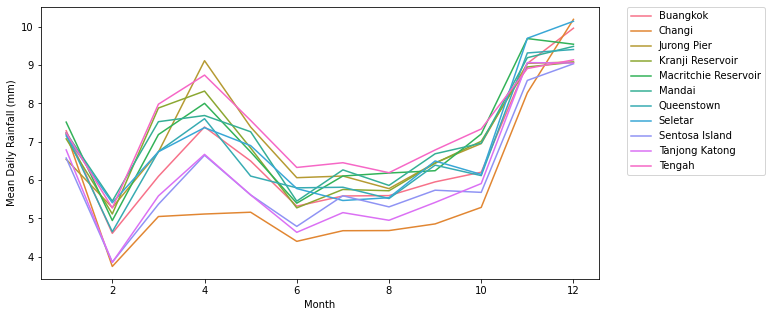

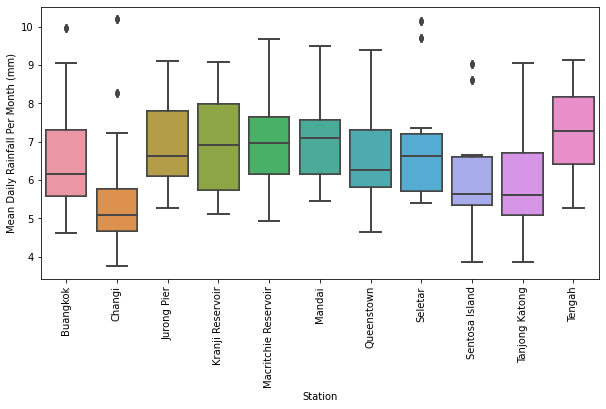

In [31]:
# Compare monthly mean daily rainfall over the 41 years
df_mean = df.groupby(['station','month_']).mean() # Average rainfall data after grouping all data by station and month
df_mean['station'] = [a[0] for a in df_mean.index]
df_mean['month'] = [a[1] for a in df_mean.index]

fig, ax = plt.subplots(figsize = (10,5))
sns.lineplot(x = 'month', y = 'impute', hue = 'station', data = df_mean, ax = ax)
ax.set_xlabel('Month')
ax.set_ylabel('Mean Daily Rainfall (mm)')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Mean daily rainfall for each station resampled monthly
fig, ax = plt.subplots(figsize = (10,5))
for s in df_mean.station.unique():
    sns.boxplot(x = 'station', y = 'impute', data = df_mean, ax = ax)
ax.tick_params(axis = 'x', rotation = 90)
ax.set_xlabel('Station')
ax.set_ylabel('Mean Daily Rainfall Per Month (mm)')

The graph shows that Changi, Tanjong Katong, and Sentosa Island received less rainfall throughout the year on average. However, in December Changi suddenly becomes the wettest station before quickly becoming the driest again by February.

Similarly in the boxplot, we see that the three stations clearly receive less rainfall than the other stations on average. The plots suggests that the northern, western, and central regions of Singapore receive a similar amount of rainfall on average.

Text(0, 0.5, 'Mean Daily Rainfall Per Month (mm)')

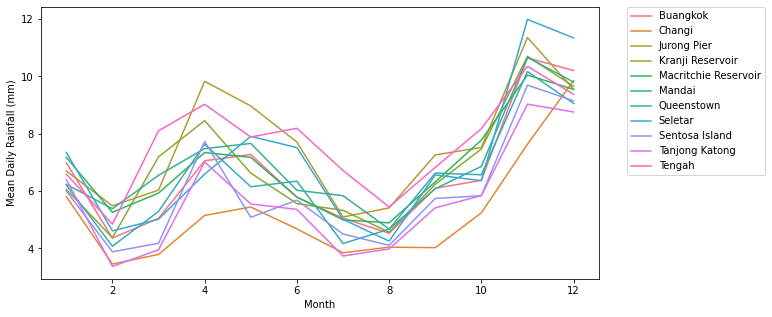

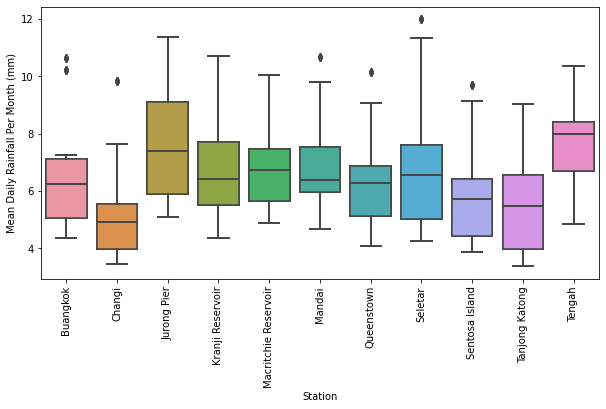

In [30]:
# Compare monthly mean daily rainfall over the past 10 years
df_mean_10 = df_10.groupby(['station','month_']).mean()
df_mean_10['station'] = [a[0] for a in df_mean_10.index]
df_mean_10['month'] = [a[1] for a in df_mean_10.index]


fig, ax = plt.subplots(figsize = (10,5))
sns.lineplot(x = 'month', y = 'impute', hue = 'station', data = df_mean_10, ax = ax)
ax.set_xlabel('Month')
ax.set_ylabel('Mean Daily Rainfall (mm)')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Mean daily rainfall for each station resampled monthly
asd = df_mean_10.copy()
asd['station'] = [a[0] for a in asd.index]

fig, ax = plt.subplots(figsize = (10,5))
for s in asd.station.unique():
    sns.boxplot(x = 'station', y = 'impute', data = asd, ax = ax)
ax.tick_params(axis = 'x', rotation = 90)
ax.set_xlabel('Station')
ax.set_ylabel('Mean Daily Rainfall Per Month (mm)')

Looking at data between 2011-2020, we see a similar pattern of Changi, Tanjong Katong, and Sentosa Island being the driest areas on average. However, a difference from the former plot is that stations Tengah and Jurong Pier appears to be more consistently wetter than the other stations.

***

<a id = '4'></a>
### 4. Conclusion
In this notebook we have explored rainfall data of Singapore, showing it seasonality and regional aspects. Furthermore, we have built four different models to forecast monthly rainfall and compared their performances.